# Receiver Function Deconvolution Tutorial
## Getting Started
### Overview
One of the innovations that resulted from the availability of digital data for recording earthquake was the technology of direct imaging with estimates of the impulse response of the earth to incident direct P or S phases. An estimate of the impulse response to a direct P or S phase has come to be called a *receiver function*.  The term *receiver function* is somewhat archaic as the original application was strictly to estimate near receiver crustal structure by inversion of stacked receiver function estimates.   More recent work has extended the concept and the same estimates are now routinely used to image the transition zone through techniques where "receiver function" is a misleading title.  Nonetheless, we use that title here because it is standard terminology.

MsPASS has an extensive collection of standard algorithms used for receiver function deconvolution.  It also has some novel methods.  The first section of this tutorial shows how to run the more conventional methods and the second main section shows how to run additional methods developed by the authors of MsPASS.   
### Generating Simulation Data
Before we can run the algorithms we need data.  For this exercise we will use simulation data.  Simulation data has the advantage that you know the answer and can evaluate the strengths and weaknesses of different algorithms. 

Note this section uses a set of specialized python functions contain in a module loaded as the first line of the cell below.  Students are encouraged to look through that python code to understand how the simulations are generated here.  Students may also want to tweek that code to study the problem further.  We intentionally kept these details out of this tutorial to focus on the point of the exercise rather than the details of how we did the simulation.

In [1]:
import decon_data_generators as simulator
wavelet=simulator.make_simulation_wavelet()

That function returns a MsPASS TimeSeries data object containing the source wavelet we will use in this simulation.  The next cell plots this wavelet.  

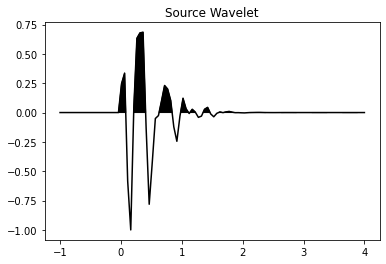

In [2]:
from mspasspy.graphics import SeismicPlotter
import matplotlib.pyplot as plt
plotter=SeismicPlotter(normalize=True,title='Source Wavelet')
plotter.change_style('wtva')
plotter.plot(wavelet)

Next we will run a small function that generates the impulse response that represents the seismogram our deconvolutions will attempt to reconstruct.

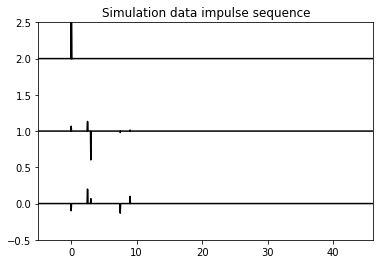

In [3]:
dimp=simulator.make_impulse_data()
plotter.title="Simulation data impulse sequence"
plotter.plot(dimp)

Noting the top signal is our simulated longitudinal component, the middle radial, and the bottom transverse.  This simulation is idealized with the longitudinalcomponent being a single pure impulse simulating a direct P wave signal. That is never the case in reality, but an assumption the standard methods we will apply here assume that is the case.  Our simulated radial and tranverse are not based on any physical model, but an made up sequence created for this first, ideal simulation.

Our (ideal) data is the source wavelet convolved with the impulse sequence above.  The small function we call in the next cell performs that convolution and update our Seismogram object, d, with that data.  The two lines at the end then plot these data.  They can be compared directly with the cell above this one: 

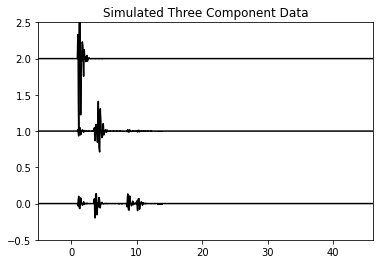

In [4]:
d=simulator.convolve_wavelet(dimp,wavelet)
plotter.title="Simulated Three Component Data"
plotter.plot(d)

The zero padding is important for the methods we will use here as all use Fourier transforms and without careful zero padding they can produce circular convolution artifacts.  Before we apply the deconvolution operators it might be helpful to zoom into the nonzero parts of this signal.

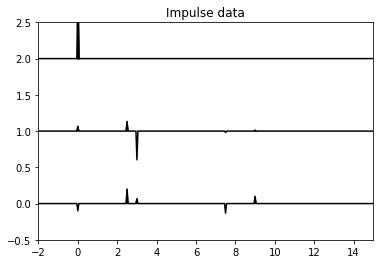

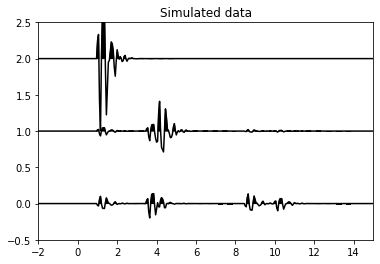

In [5]:
from mspasspy.ccore.seismic import TimeWindow
from mspasspy.algorithms.window import WindowData
twin=TimeWindow(-2.0,15.0)
dizoom=WindowData(dimp,twin)
dzoom=WindowData(d,twin)
plotter.title="Impulse data"
plotter.plot(dizoom)
# We defined plt as the module for matplotlib which plotter used 
# so we can use this to force a show
plt.show()
plotter.title="Simulated data"
plotter.plot(dzoom)
plt.show()

## Scalar Deconvolution Methods
We have implemented a set of the most common receiver function methods that we generically classify as *scalar deconvolution method*.   By that we mean the operator is applied on pairs of scalar (single-channel) signals where one signal is assumed to be the wavelet and the other is the data to be deconvolved.   The next section describes a generalization that can be used for array-based deconvolution and intrinsically handles three-component data objects (MsPASS Seismogram objects).  

The following methods are available in MsPASS under a common wrapper we will describe momentarily:
1.  The so called water-level method.
2.  Damped least squares implemented in the frequency domain
3.  The multitaper method as implemented by Park and Levin.
4.  A variant of the multitaper method using spectral division.
5.  The generalized iterative method (planned but not working at the time this tutorial was written).  

The "common wrapper" noted above is a set of python code used to interact with the lower level code that does the numerics.  That code is written in C++ and the compiled code is in the module *mspass.ccore.algorithms.deconvolution*.   The wrappers provide a simplified, common interface to this set of algorithms and provide a mechanism to utilize the parallel framework of MsPASS.   Hence, the first step is to load the things we need:

In [6]:
from mspasspy.algorithms.RFdeconProcessor import RFdeconProcessor
from mspasspy.algorithms.RFdeconProcessor import RFdecon

We stopped here because it is important to distinguish between the two entities we just loaded from a common module.  
- *RFDeconProcessor* is a python class defining a processing object. The algorithm selected is defined in the creation of this abstract entity.
- *RFdecon* is a function that applies the selected algorithm to the data we give it.

### Water-level deconvolution
With that background, let's apply this using the simplest deconvolution algorithm commonly called the water-level method:

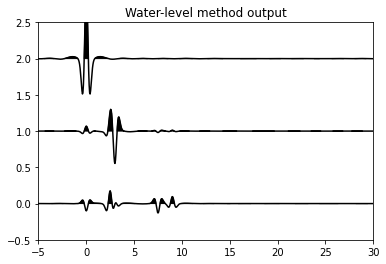

In [7]:
#This creates the processing object that will implement the 
# water-level method
wlprocessor=RFdeconProcessor(alg="WaterLevel")
#processor=RFdeconProcessor(alg="LeastSquares")

# Run that processor on our data and plot the output
decondata=RFdecon(wlprocessor,d)
plotter.title="Water-level method output"
plotter.plot(decondata)
plt.show()

### Damped least squares deconvolution
Perhaps the most common method to regularize deconvolution is damped least squares.  Although not really that common in receiver function processing it is without doubt the most commonly used deconvolution regularization because standard predictive deconvolution operators used in seismic reflection always uses this method.  In that field the damping parameter is commonly called "prewhitening" for obscure reasons best left to discussion in courses on signal processing.

To run the damped least squares estimator we can just redefine the operator and run it again like this:

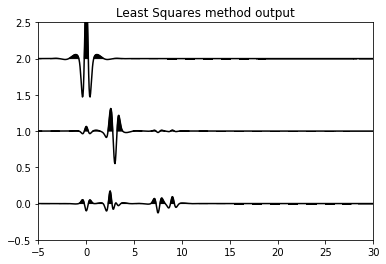

In [8]:
lsprocessor=RFdeconProcessor(alg="LeastSquares")
decondata=RFdecon(lsprocessor,d)
plotter.title="Least Squares method output"
plotter.plot(decondata)
plt.show()

### Multitaper Deconvolution
Next let's run the two operators that use the multitaper method to estimate the inverse for the deconvolution.   These require a minor change in the run procedure.   The reason is that the methods we implemented, which are based on the original work by Park and Levin, use a frequency dependent regularization.  That regularization has the valuable feature of being a scaled version of the spectrum of an estimate of noise.  Hence, to run that algorithm the processor must be given an estimate of the noise.  The default way to handle that with this processor is to define a noise window prior to the P wave arrival and estimate the noise spectrum in that time window.  

The simulation above was noise free and had an insufficient window before time 0 (P arrival time reference) to produce a reasonable estimate.  This small block of code will pad the data on the front, add colored noise at a specified level, and plot the result.  

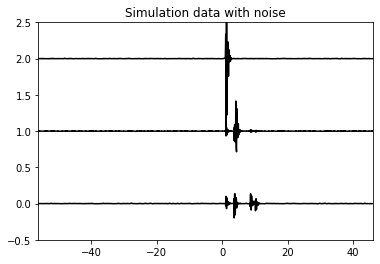

In [9]:
dwn=simulator.addnoise(d,nscale=5.0)
plotter.title="Simulation data with noise"
plotter.plot(dwn)
plt.show()

For this test the parameters we will apply for the multitaper methods will extract a noise estimate from 45 s before the P time (-45 s in the plot) to 5 s before P (-5 s in the plot) and use the spectrum of that noise to produce a frequency dependent regularization of the deconvolution operator.  The operator will also define the so called time-bandwidth product to 2.5 and use 4 tapers, which are the parameters found in Park and Levin's original paper.   The output is shaped to the same Ricker wavelet used above.

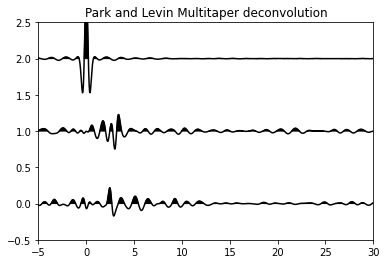

In [10]:
mtxcproc=RFdeconProcessor(alg="MultiTaperXcor")
decondata=RFdecon(mtxcproc,dwn)
plotter.title="Park and Levin Multitaper deconvolution"
plotter.plot(decondata)
plt.show()

In MsPASS we also have implemented a variation on Park and Levin's algorithm that is essentially a generalization of the water level method.   Details are documented elsewhere (to be determined at this writing but needed in a section of the reference manual with background theory) but the basic concept is that the water level scales with the noise spectrum.  That is, at an frequency *f* the water level is defined by *f* * *damp* where *damp* is a variation of a damping parameter.   A peculiarity of this algorithm is that *damp* should normally be greater than one to suppress noise.   When *damp<1* it is guaranteed that noise will be amplified in the deconvolved data relative to the input.  Here is the output of that algorithm:

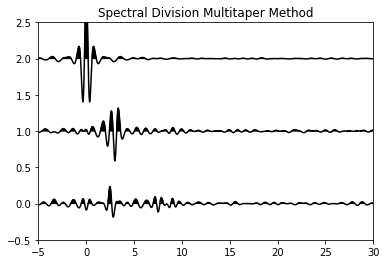

In [11]:
mtspecproc=RFdeconProcessor(alg="MultiTaperSpecDiv")
decondata=RFdecon(mtspecproc,dwn)
plotter.title="Spectral Division Multitaper Method"
plotter.plot(decondata)
plt.show()

### Comparisons of Operator Performance
First, lest you judge the multitaper methods too harshly keep in mind we ran the water-level and least squares methods on noise-free data.   Hence, let's repeat run them on the same data with added noise we used for the multitaper method:

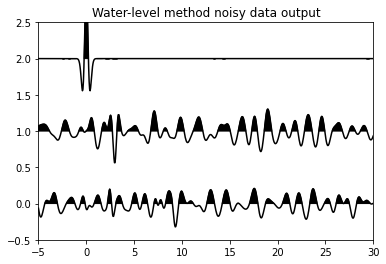

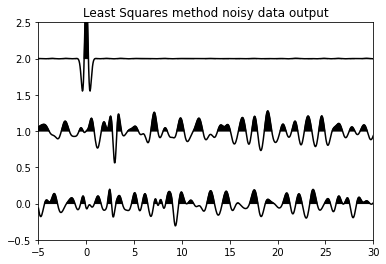

In [12]:
decondata=RFdecon(wlprocessor,dwn)
plotter.title="Water-level method noisy data output"
plotter.plot(decondata)
plt.show()
decondata=RFdecon(lsprocessor,dwn)
plotter.title="Least Squares method noisy data output"
plotter.plot(decondata)
plt.show()

The reason the water-level and least squares method performed so badly on data with noise is this test violated an implicit assumption in both method.  That is, the form of damping we used, in particular, is often developed as an optimal deconvolution operator for white noise (*white* in this context means there is no frequency dependence).   Real data recorded on modern instrumentation nearly always violates that assumption and is, in fact, more like our simulation.  To see that, this small script computes and plots the spectrum of the time windows we used around the vertical component signal and the noise section.

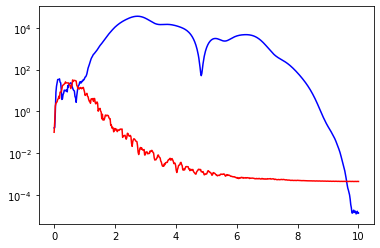

In [13]:
from mspasspy.ccore.algorithms.deconvolution import MTPowerSpectrumEngine
from mspasspy.ccore.algorithms.basic import ExtractComponent
import numpy as np
engine=MTPowerSpectrumEngine(1024,4.0,6)
sigwindow=TimeWindow(-5.0,30.0)
nwindow=TimeWindow(-45.0,-5.0)
z=ExtractComponent(dwn,2)
sig=WindowData(z,sigwindow)
noise=WindowData(z,nwindow)
sigspec=engine.apply(sig)
nspec=engine.apply(noise)
fs=np.linspace(0.0,sigspec.Nyquist(),sigspec.nf())
fn=np.linspace(0.0,nspec.Nyquist(),nspec.nf())
plt.semilogy(fs,sigspec.spectrum,'b-',fn,nspec.spectrum,'r-')
plt.show()

where the red curve is the noise spectrum and the blue curve is the signal spectrum.   The relative spectra have the same characteristic of real broadband data wherein the noise is "colored" at low frequencies.   The frequency scale in this simulation is off by about an order of magnitude, however, as earth noise in receiver function processing is dominated by microseism noise that peaks around 7 and 15 s. Nonetheless this simulation demonstrates an important failing of both the water-level and least square methods;  they can fail badly even on high signal to noise ratio data.   A typical solution used to address this problem is to increase the regularization parameters to reduce noise amplification in the output.   We leave that and some others as part of exercises for the student below.  

For each of these exercises you will need to launch your favorite editor.  Open the file found in this directory called RFdeconProcessor.pf. Note the file has groups of parameters like this one:
```
WaterLevel &Arr{
water_level 0.1
operator_nfft 1024
shaping_wavelet_dt 0.05
# these are appropriate for scalar data defined in test script
deconvolution_data_window_start -5.0
deconvolution_data_window_end 30.0
target_sample_interval 0.05
shaping_wavelet_type ricker
shaping_wavelet_frequency 1.0
shaping_wavelet_frequency_for_inverse 1.0
}

```
for the water-level method. When the RFdecon class is created this file is parsed for the method and the operator is created using the parameters for that method (in the case above water-level).   

Each exercise requires you to tweek one or more parameters in this file, save the result, and then rerun one or more cells in this notebook.  

1.  Explore the effects of increasing the regularization level on each of these methods.  The regularization parameter is called *damping_factor* for all but the water-level method where it is called *water_level*.  
2.  Vary the *time_bandwidth_product*  and *number_tapers* parameters in the multitaper methods to see if it has any significant effect (Note:  standard guidance is the number of taper must be less than 2(*time_band_product*). 
3.  Regenerate the noisy data with a different noise spectrum and study the results.   This is easily done by altering the parameters of this function we used to generate the noisy data:
```
def addnoise(d,nscale=1.0,padlength=1024,npoles=3,corners=[0.1,1.0]):
    """
    Helper function to add noise to ndarray d.  The approach is a 
    little weird that we shift the data to the right by padlength 
    adding filtered random data to the front if the signal.   
    The code later sets t0 correctly based on padlength - ok 
    for a test program but do not recycle me.
    
    :param d: data to which noise is to be added and padded
    :param scale:  noise scale for gaussian normal noise
    :param padlength:   data padded on front by this many sample of noise
    """
```

### Resolution Analysis
A final took the RFdecon operators have to appraise the validity of a result is a form or resolution analysis.  Readers familiar with inverse theory should know about the idea of a resolution matrix computed for earth model inversions.  (In tomography these are sometimes computed as point estimates as how well one cell in the model can be recovered with all others zero.)   In deconvolution there is one and only one resolution function computed as *r(t) = i(t) * d(t)* where *i* is the inverse filter computed from the data signal *d*.  In deconvolution theory *r* is commonly called the *actual output*.  The deconvolution operators in MsPASS never attempt what is sometimes called a *spiking filter*.   A spiking filter aims to shape the actual output to a pure impulse a lag 0.  All the methods used here will tend to produce an output that rings at frequencies near the Nyquist if we aimed to produce a spike as the actual output.  RFdecon has a list of possible *shaping wavelets* that can be used to design the deconvolution operator.  In these tests we have used a Ricker wavelet (also sometimes called the Mexican Hat function) which is the second derivative of a Gaussian function.  Ricker wavelets are a common shaping wavelet used in reflection processing.  Alternatives that can be selected are a Gaussian pulse  of a specified width, a zero phase Butterworth bandpass filter with specified corners, and zeroth order Slepian pulse (a variant of Gaussian with lower sidebands).   

RFdecon allows one to extract and plot the shaping wavelet through the *ideal_output* method and the actual output through the *actual_output* method.  That process is illustrated below.  A VERY IMPORTANT state issue, however, is that the output of *actual_output* is the result of the operator computed from the last time the processor was run on a specific piece of data.  i.e. each time the processor is called with new data the actual output will be slightly different.  

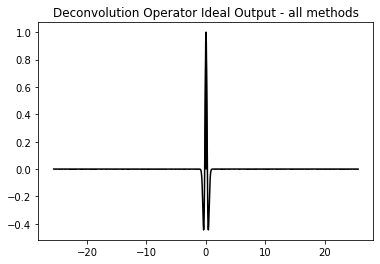

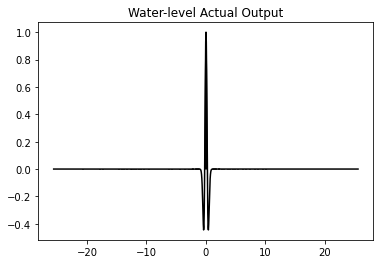

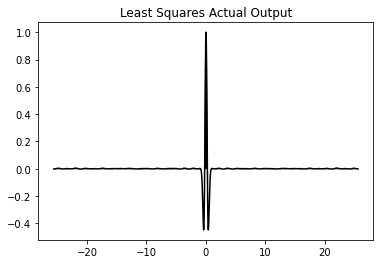

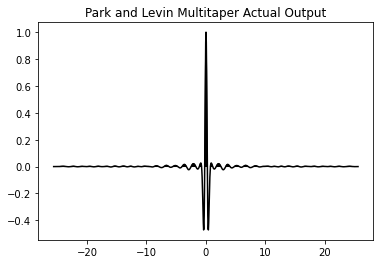

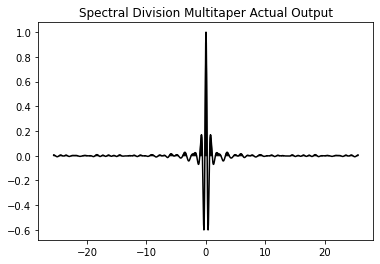

In [14]:
from mspasspy.ccore.seismic import TimeSeries
ao1=wlprocessor.actual_output()
io=wlprocessor.ideal_output()
# First we plot the idea output - all methods use this same shaping wavelet
# Hence we only plot it once.  If the parameter file is altered with 
# different shaping wavelets for different methods each needs a separate call 
# to the ideal_output method
plotter.title='Deconvolution Operator Ideal Output - all methods'
plotter.plot(TimeSeries(io))
plt.show()

plotter.title='Water-level Actual Output'
plotter.plot(TimeSeries(ao1))
plt.show()

ao2=lsprocessor.actual_output()
plotter.title='Least Squares Actual Output'
plotter.plot(TimeSeries(ao2))
plt.show()

ao3=mtxcproc.actual_output()
plotter.title='Park and Levin Multitaper Actual Output'
plotter.plot(TimeSeries(ao3))
plt.show()

ao4=mtspecproc.actual_output()
plotter.title='Spectral Division Multitaper Actual Output'
plotter.plot(TimeSeries(ao4))
plt.show()


You may want to explore how the actual output depends on the regularization parameter for each of these methods.  To do that edit the RFdeconProcessor.pf file as described above, run the cell that creates the processor of choice, and then rerun the cell above.  Alternatively, you can just tell jupyter to rerun this whole notebook after each edit.

## Color Noise Regularized Deconvolution (CNR3Decon):
The test above illustrates a fundamental problem with conventional methods of "receiver function" deconvolution even in the ideal situation when the wavelet is known to high accuracy.  That is, seismic noise is highly colored and all of these methods except the multitaper methods are descendent of reflection processing algorithms in general and variations of Wiener filters in particular.  Wiener filter methods make assumption that the noise to be suppressed is white.  As noted above that is never true with passive array data recording of teleseismic body waves because the band of interest always crosses the strong peak from microseisms.   Furthermore, unlike reflection processing where the source amplitude and spectrum are approximately constant earthquake signal amplitudes vary by many orders of magnitude and as any seismologists knows the source spectrum varies systematically with magnitude (amplitude).   Hence, the common practice of using a single recipe to process an entire data set leads to inconsistencies in the result that are commonly handled by aggressive editing of the output.   That problem leads to inefficient handling of data with a large fraction of high signal to noise ratio events discarded for sometimes mysterious reasons.

To address this issue we developed a novel method in MsPASS with the cryptic name CNR3CDecon.  The name is intended to be mnemonic for Colored Noise Regularized Three-Component (3C) Deconvolution.   We can illustrate it's behavior by applying it to the same data above that we showed creates issues for all the methods described above:

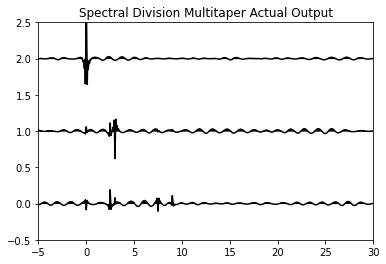

In [15]:
from mspasspy.ccore.utility import AntelopePf
from mspasspy.ccore.algorithms.deconvolution import CNR3CDecon
pf=AntelopePf('CNR3CDecon.pf')
CNRDecon=CNR3CDecon(pf)
# There is currently a bug that if wavelet loads before noise we
# get a seg fault
CNRDecon.loadnoise_wavelet(noise)
CNRDecon.loadwavelet(sig)
#n3c=WindowData(dwn,nwindow)
#CNRDecon.loadnoise_data(n3c)
#d_to_process=WindowData(dwn,sigwindow)
n3c=WindowData(dwn,nwindow)
CNRDecon.loadnoise_data(n3c)
CNRDecon.loaddata(dwn,False)
dout=CNRDecon.process()
plotwindow=TimeWindow(-5.0,30.0)
dow=WindowData(dout,plotwindow)
plotter.plot(dow)
plt.show()



This estimate is clearly an extreme improvement over all the other methods both in terms of resolution and noise reduction.  The reason is this algorithm dynamically adjusts the estimate not be shaped to a zero-phase, butterworth, bandpass filter (currently frozen at 2 poles for both ends of the passband).  We can see that by again plotting the actual and ideal outputs of this operator: 

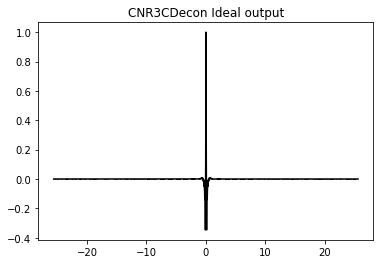

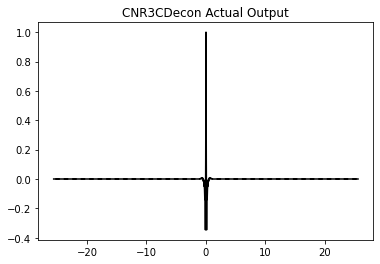

In [16]:
# CNR3CDecon has a different buffer size than the RFdecon methods
# We cut the outputs here to this window so plots produced can be compared
reswindow=TimeWindow(ao4.t0,ao4.endtime())
ioc=CNRDecon.ideal_output()
ioc=WindowData(ioc,reswindow)
plotter.title='CNR3CDecon Ideal output'
plotter.plot(TimeSeries(ioc))
plt.show()
aoc=CNRDecon.actual_output()
aoc=WindowData(aoc,reswindow)
plotter.title='CNR3CDecon Actual Output'
plotter.plot(TimeSeries(aoc))
plt.show()

These figures demonstrate that not only is the output cleaner the resolution is much higher. The details of this algorithm are best described elsewhere as we would quickly get mired in some technical details.   The essence of the idea, however, can be gleaned from the plot of the power spectrum of the signal and noise for the wavelet seen above in comparison to the power spectrum of the shaping wavelets for the different methods.  For the RFdecon methods we need only plot the spectrum of the fixed Ricker wavelet used in all of those methods while for CNR3CDecon we plot the spectrum of the signal shown in the figure above:

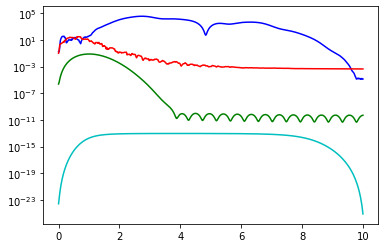

In [17]:
# We use sigspec and noisespec computed above exploiting jupyter here so 
# don't try just pasting this in elsewhere without recognizing that.
iocspec=engine.apply(TimeSeries(ioc))
iorfdspec=engine.apply(TimeSeries(io))
#assume both ideal output signals are the same length so the spectra are the same length
fio=fn=np.linspace(0.0,iocspec.Nyquist(),iocspec.nf())
plt.semilogy(fs,sigspec.spectrum,'b-',
             fn,nspec.spectrum,'r-',
            fio,iorfdspec.spectrum,'g-',
            fio,iocspec.spectrum,'c-')
plt.show()

There is a signal scaling issue in the current implementation, but the plot is actually clearer plotted without a scaling correction.  The red and blue curves are the same as above:  noise and signal spectrum respectively.  The green curve is the spectrum of the Ricker shaping wavelet used for the RFdecon methods and the cyan curve is the shaping wavelet determined dynamically by CNR3CDecon. 

The reason the Ricker illustrated is a bad shaping wavelet for this simulation is that it's peak amplitud eis around the point there the signal and noise amplitudes cross.   Shaping to a Ricker amplitudes low frequency (here meaning below 1 Hz) noise.  CNR3CDecon searched for the band where the signal-to-noise ratio was above a threshold, which in this simulation was a value of 2.0.   The Butterworth filter it then used has a corner abound 1 Hz and a 80% of Nyquist, which is a limit set to keep the recursive filter stable (recursive Butterworth filters become unstable if the upper corner gets too close to Nyquist).   Different signal or noise conditions for different data or wavelet combinations will cause the bandwidth to be adjusted.   Thus, an unusual property of the output of CNR3CDecon is the the ideal output is different for every seismogram.   For this reason when this algorithm is applied to data actual output should be saved.   The ideal output does not need to be saved as it is defined by corner frequencies posted to the Metadata of the output.  We can see that here:

In [18]:
print(dout)

{'CNR3CDecon_bandwidth': 17.579126, 'CNR3CDecon_high_corner': 7.988588, 'CNR3CDecon_high_f_snr': 536.894924, 'CNR3CDecon_low_corner': 1.055635, 'CNR3CDecon_low_f_snr': 2.360498, 'delta': 0.050000, 'npts': 4096, 'starttime': -35.050000}


This says the passband of the ideal output is from 0.97 to 8.0 Hz and the signal bandwidth is 18 dB. These parameters can be used to filter data with MongoDB to only select outputs where the data are within a give passband.    